In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# Step 1: Loading Data
Below data is loaded, and then shuffled. Shapes are printed for understanding of the data structure

In [2]:
clean = np.loadtxt('wifi_db/clean_dataset.txt')
np.random.shuffle(clean)
print(clean.shape)

noisy = np.loadtxt('wifi_db/noisy_dataset.txt')
np.random.shuffle(noisy)
print(noisy.shape) 

(2000, 8)
(2000, 8)


# Step 2: Creating the decision trees

### Finding the decision treee split to maximise information gain

In [3]:
def FIND_SPLIT(data_set: np.ndarray) -> tuple:
    '''
    The function FIND_SPLIT chooses the attribute and the value that results in the highest information gain.

    Inputs: data_set, an np.ndarray of the data set to split. The last column is assumed to be the class label
    Outputs: tuple consisting of the attribute and value to split the data for the highest information gain
    '''


    def informationGain(data_set_full: np.ndarray, data_set_left: np.ndarray, data_set_right: np.ndarray) -> float:
        '''
        informationGain takes the full data set, and the two subsets which it is divided into. It returns the information gain.

        Inputs: data_set_full, np.ndarray of full dataset
                data_set_left, np.ndarray of left subsection of dataset
                data_set_right np.ndarray of right subsection of dataset
        Outputs: float, the information gain of the sectioning
        '''
        return entropy(data_set_full) - remainder(data_set_left, data_set_right)



    def entropy(data_set: np.ndarray) -> float:
        '''
        Calculates the entropy of a dataset.

        Inputs: data_set, where column with index -1 is assumed to be the label
        Outputs: float, the entropy of the data_set
        '''
        data_set = data_set[data_set[:, -1].argsort()]
        data_labels = data_set[:,-1]
        unique_labels = np.unique(data_labels)

        probabilities = np.zeros_like(unique_labels)

        for i, label in enumerate(unique_labels):
            probabilities[i] = np.sum(data_labels == label) / len(data_labels)

        entropy = - np.sum(np.log2(probabilities) * probabilities)
        
        return entropy



    def remainder(data_set_left: np.ndarray, data_set_right: np.ndarray) -> float:
        '''
        Calculates the remainder two subsets.

        Inputs: data_set_left, np.ndarray of the left subsection
                data_set_right, np.ndarray of the right subsection

        Outputs: float, the remainder of the subsections

        '''
        no_samples_left = len(data_set_left)
        no_samples_right = len(data_set_right)
        no_samples_tot = no_samples_left + no_samples_right

        entropy_left = entropy(data_set_left)
        entropy_right = entropy(data_set_right)

        remainder = no_samples_left * entropy_left / no_samples_tot + no_samples_right * entropy_right / no_samples_tot

        return remainder
    

    attributes = data_set.shape[1] - 1

    running_score = np.zeros((attributes, 2))

    for i in range(attributes):

        highest_information_gain = 0
        best_split = None

        data_set = data_set[data_set[:, i].argsort()]
        unique_values = np.unique(data_set[:, i])
        possible_splits = (unique_values[:-1] + unique_values[1:]) / 2

        for split in possible_splits:

            left_index = data_set[:, i] > split
            right_index = left_index == False

            data_set_left = data_set[left_index]
            data_set_right = data_set[right_index]

            information_gain = informationGain(data_set, data_set_left, data_set_right)

            if information_gain > highest_information_gain:
                highest_information_gain = information_gain
                best_split = split

        running_score[i,0] = highest_information_gain
        running_score[i,1] = best_split

    attribute_to_split = np.argmax(running_score[:, 0])
    split_value = running_score[attribute_to_split, 1]

    return (attribute_to_split, split_value)

### Training the binary decision tree

In [4]:
def decisionTreeLearning(train_dataset: np.ndarray, depth: int = 0, max_depth: int = 100, min_samples_leaf: int = 1) -> tuple[dict, int]:
    '''
    Takes as arguments a matrix containing the dataset and a depth variable (which is used to compute the maximal depth
    of the tree, for plotting purposes for instance). The label of the training dataset is assumed to be the last
    column of the matrix.

    Inputs: train_dataset, np.ndarray
            depth, int, to keep track of how deep down the tree the node is
            max_depth, int which can be used to regularise the classifier
            min_samples_leaf, int, the minimum samples on a node before it becomes a leaf. Used for regularisation
    Outputs: node, dictionary
             depth, int

    '''

    if len(set(train_dataset[:, -1])) == 1:
        leaf_val = train_dataset[0,-1]
        #for leaf the leaf_vale is saved under the attribute key
        leaf_node = {'attribute': None, 'value': leaf_val,
                     'left': None, 'right': None, 'isLeaf': True}
        
        return leaf_node, depth
    
    if depth >= max_depth:
        counts = np.bincount(np.int64(train_dataset[:, -1]))
        leaf_val = np.argmax(counts)

        leaf_node = {'attribute': None, 'value': leaf_val,
                     'left': None, 'right': None, 'isLeaf': True}
        return leaf_node, depth
    
    if len(train_dataset[:, -1]) <= min_samples_leaf:
        counts = np.bincount(np.int64(train_dataset[:, -1]))
        leaf_val = np.argmax(counts)

        leaf_node = {'attribute': None, 'value': leaf_val,
                        'left': None, 'right': None, 'isLeaf': True}
        return leaf_node, depth 

    attribute, value = FIND_SPLIT(train_dataset)

    node = {'attribute': attribute, 'value': value, 'left': None, 'right': None, 'isLeaf': False}
   
    l_dataset = train_dataset[train_dataset[:, attribute] <= value]
    node['left'], l_depth = decisionTreeLearning(l_dataset, depth = depth+1, max_depth = max_depth, min_samples_leaf = min_samples_leaf) #shoud we sort this?

    r_dataset = train_dataset[train_dataset[:, attribute] > value]
    node['right'], r_depth = decisionTreeLearning(r_dataset, depth = depth+1, max_depth = max_depth, min_samples_leaf = min_samples_leaf)
   
    return node, max(l_depth, r_depth)

### Classification using the decision tree

In [5]:
def sampleClassification(root: dict, sample: np.ndarray) -> int:
    '''
    Classifies a sample using the decision tree

    Inputs: root, dictionary containing the root of the tree
            sample, np.ndarray containing the sample features
    Outputs: integer label for the sample
    '''
   
    if root['isLeaf']:
        #do the return instead of print int he future
        return root['value']
   
    col = root['attribute']
    val = root['value']

    if sample[col] <= val:
        return sampleClassification(root['left'], sample)
    else:
        return sampleClassification(root['right'], sample)


def decisionTreeClassifier(data: np.ndarray, root: dict) -> np.ndarray:
    '''
    Takes a whole dataset and the root of the decision tree and labels each point. 
    Assumes the last column is true labels.

    Inputs: data, np.ndarray matrix containing test data
            root, dictionary containing the root of the decision tree
    Outputs: np.ndarray containing the predicted labels
    '''
    
    predictions = np.zeros(len(data))

    for i in range(len(data)):
        predictions[i] = sampleClassification(root, data[i,:-1])
    
    return predictions

### Visualizing the decision tree

In [6]:
def plotTree(begin_root: dict) -> None:
    '''
    plotTree takes the the root of the tree and plots it by creating a figure, calling the recursive function 
    recursivelyPlotTree and then setting legend and labels of the plot

    Inputs: begin_root, a dictionary containing the root of the decision tree
    Outputs: none
    '''

    def recursivelyPlotTree(node:dict, parent_x:float, parent_y:float, width:float, depth:int, direction=None, colors = ['red', 'green', 'blue', 'yellow']) -> None:

        if direction == None:
            x = 0
            y = 0

        elif direction == 'right':
            x = parent_x + (width / 2)
            y = parent_y - depth

        elif direction == 'left':
            x = parent_x - (width / 2)
            y = parent_y - depth

        if not node['isLeaf']:

            # Plot Node and line from paren
            plt.plot([parent_x, x], [parent_y, y], '--', c = 'grey')
            plt.scatter(x, y, color = 'black', s = 100)
            plt.text(x, y+depth/4, "X{} < {}".format(node['attribute'], node['value']), ha='center', va='center', weight='bold')
            
            # Recursively plot the left and right subtrees
            recursivelyPlotTree(node["left"], x, y, width / 2, depth, "left")
            recursivelyPlotTree(node["right"], x, y, width / 2, depth, "right")

        elif node['isLeaf']:
            # If it's a leaf node, plot its class label, encoded by the color
            label = int(node['value'])
            c = colors[label - 1]

            # Plot leaf and line from parent
            plt.plot([parent_x, x], [parent_y, y], '--', c = 'grey')
            plt.scatter(x, y, color = c, marker='s', s = 500)

    # Create a figure and call the plotTree function
    plt.figure(figsize=(40, 10))
    plt.rcParams.update({'font.size': 15})
    colors = ['red', 'green', 'blue', 'yellow']
    plt.axis('off')
    recursivelyPlotTree(begin_root, 0, 0, 2, 5, colors = ['red', 'green', 'blue', 'yellow'])

    # Create legend
    patches = []
    for i in range(1, 5):
        patches.append(mpatches.Patch(color = colors[i-1], label = 'Room Label {}'.format(i)))
    plt.legend(handles = patches)

    plt.show()

#### Example of training a shallow tree and visualising it

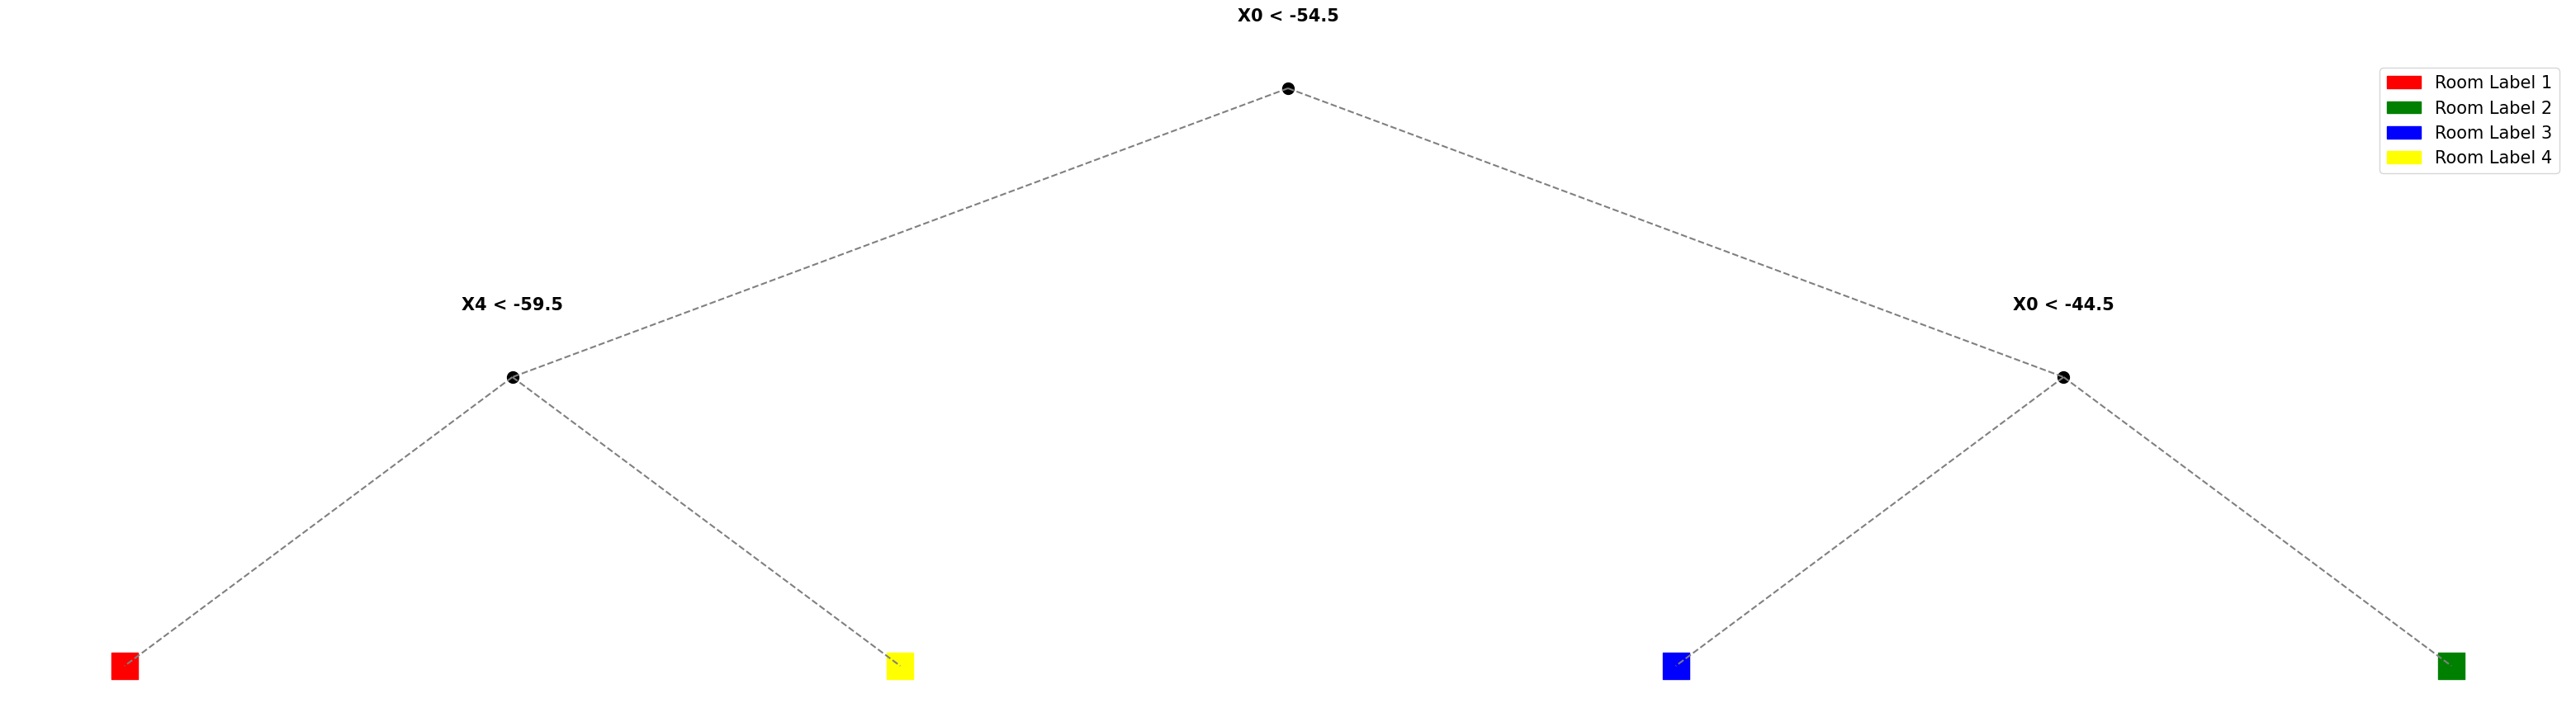

In [7]:
begin_root, _ = decisionTreeLearning(clean, max_depth = 2)
plotTree(begin_root)

# Step 3: Evaluation

### Function to evaluate accuracy of decision tree

In [8]:
def decision_tree_acc(root: dict, data_to_test: np.ndarray) -> float:
    '''
    XXX takes the root of a decision tree as well as a data set to test and 
    returns the classification accuracy
    
    Inputs: root, a dictionary of the root of the tree
            data_to_test, np.ndarray containing 7 columns of data as well as a final column of labels
    Outputs: float, the classification accuracy of the decision tree on the data set
    '''

    pred = decisionTreeClassifier(data_to_test, root)
    return np.sum(pred == data_to_test[:,-1]) / len(data_to_test)

### Calculating and displaying the confusion matrix

In [9]:
def confusion_matrix(y_true: np.ndarray, y_prediction: np.ndarray, class_labels = []) -> np.ndarray:
  '''
    Uses true and predicted values to calculate the confusion matrix.

    Inputs: y_true - array containing all the true labels
            y_pred - array containing all the predicted labels
    
    Outputs: cm - array containing the confusion matrix
             class_labels - appropriate labels for rows/column of matrix, useful for plotting
  '''
  if len(class_labels) <1:
    class_labels = np.unique(np.concatenate((y_true, y_prediction)))
  cm = np.zeros((len(class_labels), len(class_labels)))
  for (i, i_label) in enumerate(class_labels):
    true_index = (y_true == i_label)
    true = y_true[true_index]
    predictions = y_prediction[true_index]
    (unique_labels, counts) = np.unique(predictions, return_counts=True)
    cm_data = dict(zip(unique_labels, counts))

    for (j, j_label) in enumerate(class_labels):
      cm[i, j] = cm_data.get(j_label, 0)

  return cm, class_labels

def plot_confusion_matrix(cm: np.ndarray, class_labels, title: str) -> None:
  '''
    Takes a numpy array format of the confusion matrix and plots it neatly
    using matplotlib.

    Inputs: cm - array containing confusion matrix
            class_labels - list containing axis titles
            title - string containing title for cm
    Outputs: plots a confusion matrix
    '''
  plt.figure(figsize=(8,6))
  plt.imshow(cm, cmap = "GnBu")
  plt.title(title + ' Confusion Matrix')
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  tick_marks = np.arange(len(class_labels))
  plt.xticks(tick_marks, class_labels, rotation=45)
  plt.yticks(tick_marks, class_labels)
  
  for (j, i), label in np.ndenumerate(cm):
      plt.text(i, j, label, ha='center', va='center')
  plt.show()
  
  return None

### Getting performance metrics from confusion matrix

In [10]:
def accuracy(cm: np.ndarray) -> float:
    '''
      Computes the accuracy of the decision tree using the confusion matrix

      Inputs: cm - array containing the confusion matrix
      
      Outputs: np.sum(np.diag(cm)) / np.sum(cm) - The decision tree accuracy
              0 - if there is no cm the function simply returns 0
    '''
    if np.sum(cm) > 0:
      return np.sum(np.diag(cm)) / np.sum(cm)
    else:
      return 0

def precision(cm: np.ndarray) -> tuple:
  ''' 
    Computes the class precisions and macro precision of the decision tree using the confusion matrix
  
    Inputs: cm - array containing the confusion matrix
    Outputs: (p, macro_p) - tuple containing the class precisions as an array and the macro precision as a float
  '''
  p = np.zeros((len(cm)))
  for c in range(len(cm)):
    if np.sum(cm[:, c]) > 0:
      p[c] = cm[c, c] / np.sum(cm[:, c])
  macro_p = 0
  if len(p) > 0:
    macro_p = np.mean(p)
  return (p, macro_p)

def recall(cm: np.ndarray) -> tuple:
  ''' 
    Computes the class recall and macro recall of the decision tree using the confusion matrix
  
    Inputs: cm - array containing the confusion matrix
    Outputs: (r, macro_r) - tuple containing the class recall as an array and the macro recall as a float
  '''
  r = np.zeros((len(cm)))
  for c in range(len(cm)):
    if np.sum(cm[:, c]) > 0:
      r[c] = cm[c, c] / np.sum(cm[c, :])
  macro_r = 0
  if len(r) > 0:
    macro_r = np.mean(r)

  return (r, macro_r)

def f_measure(cm: np.ndarray, beta=1) -> tuple:
  ''' 
    Computes the class f-measure and macro f-measure of the decision tree using the confusion matrix
  
    Inputs: cm - array containing the confusion matrix
    Outputs: (p, macro_p) - tuple containing the class precisions as an array and the macro precision as a float
  '''
  (precisions, macro_p) = precision(cm)
  (recalls, macro_r) = recall(cm)
  assert len(precisions) == len(recalls)
  f = np.zeros((len(precisions)))
  for c, (p, r) in enumerate(zip(precisions, recalls)):
    if p + r > 0:
      f[c] = (1 + beta**2) * p * r / ((beta**2 * p) + r)
  macro_f = 0
  if len(f) > 0:
    macro_f = np.mean(f)
  return (f, macro_f)

### K-fold evaluation of decision tree

In [11]:
def kFoldTrainTest(data: np.ndarray, ind_test: int, number_folds = 10) -> tuple[np.ndarray, np.ndarray]:
    '''
    Takes the data and splits it up into folds, it then returns the fold index by ind_test as the test data and 
    the remaining folds as training data

    inputs: data, np.ndarray of data
            ind_test, int the fold number to use for testing
            number_folds, int the number of folds to split the data into
    outputs: fold_test, the data fold for testing
             fold_train, the remaining training data
    '''
    folds = np.array_split(data, number_folds)
    fold_test = folds[ind_test]
    folds = np.delete(folds, [ind_test], axis=0)
    fold_train = np.concatenate(folds)

    return fold_test, fold_train

In [12]:
def kFoldCrossValidation(data_set: np.ndarray, max_depth=100, number_folds = 10) -> np.ndarray:
    '''
    Takes the data for which to perform k-fold cross validation, the max depth of the decision trees to train
    and the number of folds to do. Returns average confusion matrix data across all folds.

    inputs: data_set, np.ndarray of data
            max_depth, int stating the max depth of decision trees it trains
            number_folds, int stating the number of folds for k-folds cross validation
    outputs: np.ndarray of the average confusion matrix across all folds 
    '''

    cm_tot = np.zeros((4,4))
    labels = np.unique(data_set[:, -1])

    for ind_test in range(number_folds):
    
        # Get fold
        fold_test, fold_train = kFoldTrainTest(data_set, ind_test)

        # Train on the training data
        root, _ = decisionTreeLearning(fold_train, max_depth=max_depth)
    
        # Get prediction from pruned test
        y_true = fold_test[:, -1]
        y_prediction = decisionTreeClassifier(fold_test, root)
        
        # Add to total cm to average later on
        cm_addition, _ = confusion_matrix(y_true, y_prediction, class_labels = labels)

        cm_tot = cm_tot + cm_addition

    avg_cm = np.round((cm_tot / number_folds), decimals=1)
    return avg_cm

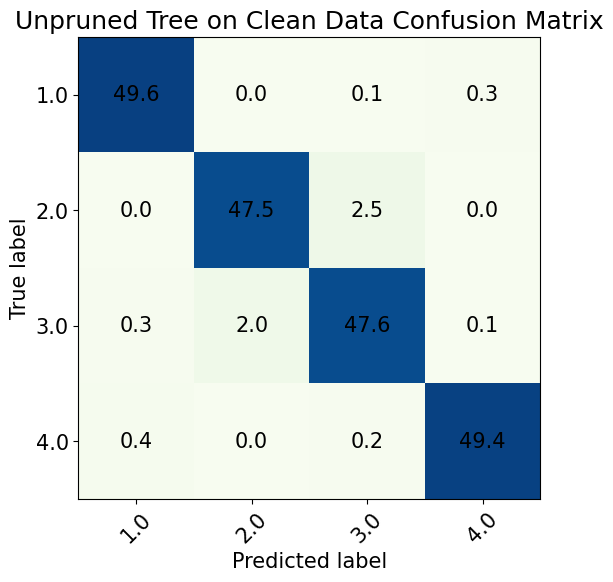

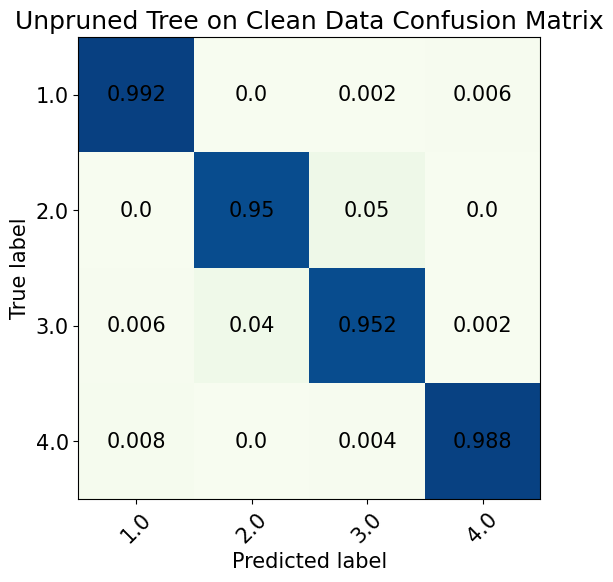

Clean Data
Accuracy: 0.9704999999999999
Precision: (array([0.9860835 , 0.95959596, 0.94444444, 0.99196787]), 0.970522943633078)
Recall: (array([0.992, 0.95 , 0.952, 0.988]), 0.9705)
F-measure: (array([0.9890329 , 0.95477387, 0.94820717, 0.98997996]), 0.9704984754693564)


In [13]:
# Setting parameters for both Noisy and clean dataset
number_folds = 10
class_labels = np.unique(clean[:, -1])
expected_class_occurence_per_fold = len(clean) / (number_folds * len(class_labels))

# Performing k-fold CV on clean dataset
cm_pruned = kFoldCrossValidation(data_set = clean)

# Getting normalised confusion matrix data
cm_pruned_normalised = np.round(cm_pruned / expected_class_occurence_per_fold, decimals=3)

# Plotting confusion matrices
plot_confusion_matrix(cm_pruned, class_labels, "Unpruned Tree on Clean Data")
plot_confusion_matrix(cm_pruned_normalised, class_labels, "Unpruned Tree on Clean Data")

# Calculate evaluation metrics
print("Clean Data")
print("Accuracy: " + str(accuracy(cm_pruned)))
print("Precision: " + str(precision(cm_pruned)))
print("Recall: " + str(recall(cm_pruned)))
print("F-measure: " + str(f_measure(cm_pruned)))

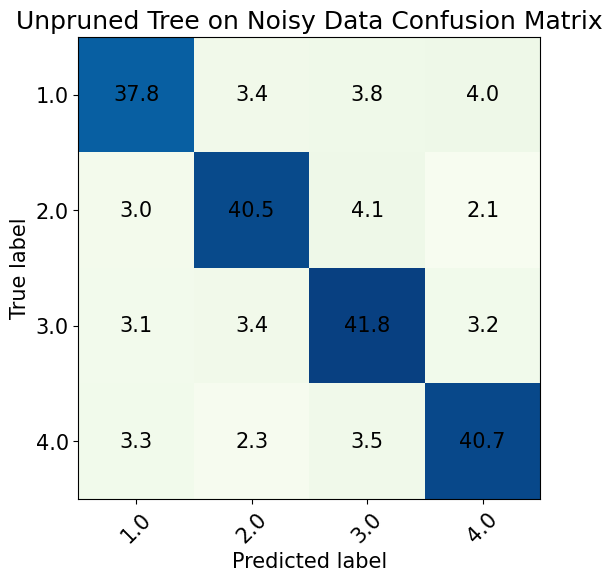

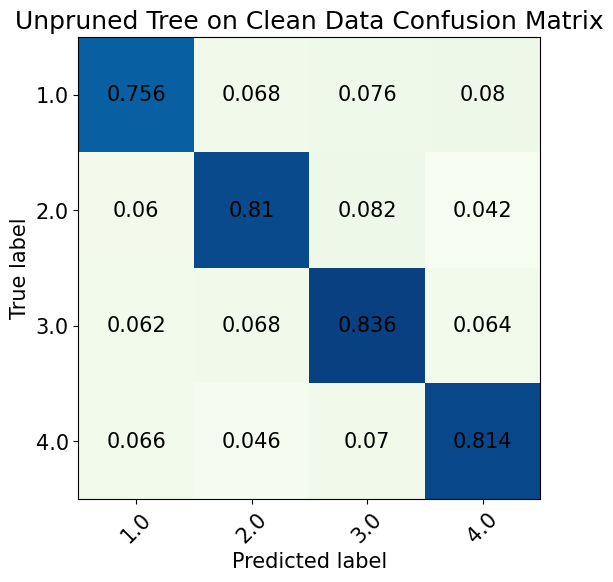

Noisy Data
Accuracy: 0.804
Precision: (array([0.80084746, 0.81653226, 0.78571429, 0.814     ]), 0.8042735003514802)
Recall: (array([0.77142857, 0.81488934, 0.81165049, 0.81726908]), 0.8038093672966955)
F-measure: (array([0.78586279, 0.81570997, 0.79847182, 0.81563126]), 0.8039189606090364)


In [14]:
# Performing k-fold CV on noisy dataset
cm_pruned = kFoldCrossValidation(data_set = noisy)

# Getting normalised confusion matrix data
cm_pruned_normalised = np.round(cm_pruned / expected_class_occurence_per_fold, decimals=3)

# Plotting confusion matrices
plot_confusion_matrix(cm_pruned, class_labels, "Unpruned Tree on Noisy Data")
plot_confusion_matrix(cm_pruned_normalised, class_labels, "Unpruned Tree on Clean Data")

# Calculate evaluation metrics
print("Noisy Data")
print("Accuracy: " + str(accuracy(cm_pruned)))
print("Precision: " + str(precision(cm_pruned)))
print("Recall: " + str(recall(cm_pruned)))
print("F-measure: " + str(f_measure(cm_pruned)))

# Step 4: Pruning (and evaluation again)

In [15]:
def decisionTreePruning(begin_root: dict, validation_data: np.ndarray, pruning_iterations = 100) -> dict:
    '''
    decisionTreePruning takes the root of the tree to pruned, the validation data to base the pruning on
    as well as how many iterations to prune, meaning how many time it will search through the pruned tree
    to look for new leafs to pruned.

    inputs: begin_root, a dictionary containing the root of the tree
            validation_data, np.ndarray containing the data and labels
            pruning_iterations, int of how many iterations to the lowest level of leaves
    output: dictionary, containing the pruned decision root
    '''

    def pruneDFS(root:dict, validation_data: np.ndarray, inference_data: np.ndarray) -> None:
        '''
        pruneDFS utilisises the depth first search algorithm to get to each node who has two children
        nodes that are both leaves. It uses the inference data to get an accuracy score without pruning and  
        then checks the validation data for the majority vote at said node. It labels the node to a leaf with 
        that value. If there is no validation data left at the node, it leaves the leaves as they are.
    
        It then tests the accuracy on the pruned tree with the inference data, and if it is higher it prunes
        the leaves. 

        inputs: root, a dictionary containing the root of the tree
                validation_data, np.ndarray containing the data and labels for majority voting
                inference_data, np.ndarray containing the data and labels for accuracy testing
        output: None, proot (decision tree we want to return) is changed in place all the time)'''
    
        if not root or root['isLeaf']:
            return 
        assert root['left'], "no left child" 
        assert root['right'], "no right child"

        # Check if it is a parent of two leaves, and that we have validation data for majority vote
        if root['left']['isLeaf'] and root['right']['isLeaf'] and validation_data.shape[0] > 0:

            acc = decision_tree_acc(begin_root, inference_data)
            root_back_l = root['left']
            root_back_r = root['right']
            root_back_val = root['value']

            root['value'] = np.bincount(validation_data[:, -1].astype(int)).argmax()  
            root['isLeaf'] = True
            root['left'] = None
            root['right'] = None
            acc_prunned = decision_tree_acc(begin_root, inference_data)
            
            if acc_prunned < acc:
                root['left'] = root_back_l
                root['right'] = root_back_r
                root['isLeaf'] = False
                root['value'] = root_back_val

        else:
            # Separate dataset into a left and right dataset
            limit_threshold = validation_data[:, root['attribute']] <= root['value']
            left_data = validation_data[limit_threshold]
            right_data = validation_data[limit_threshold == False]
            
            # Pass left and right data set
            pruneDFS(root['left'], left_data, inference_data)
            pruneDFS(root['right'], right_data, inference_data)

    for _ in range(pruning_iterations):
        pruneDFS(
            root = begin_root,
            validation_data = validation_data,
            inference_data = validation_data
            )
    
    return begin_root

### Example of pruning effects on noisy dataset

The unpruned tree test accuracy: 0.7725


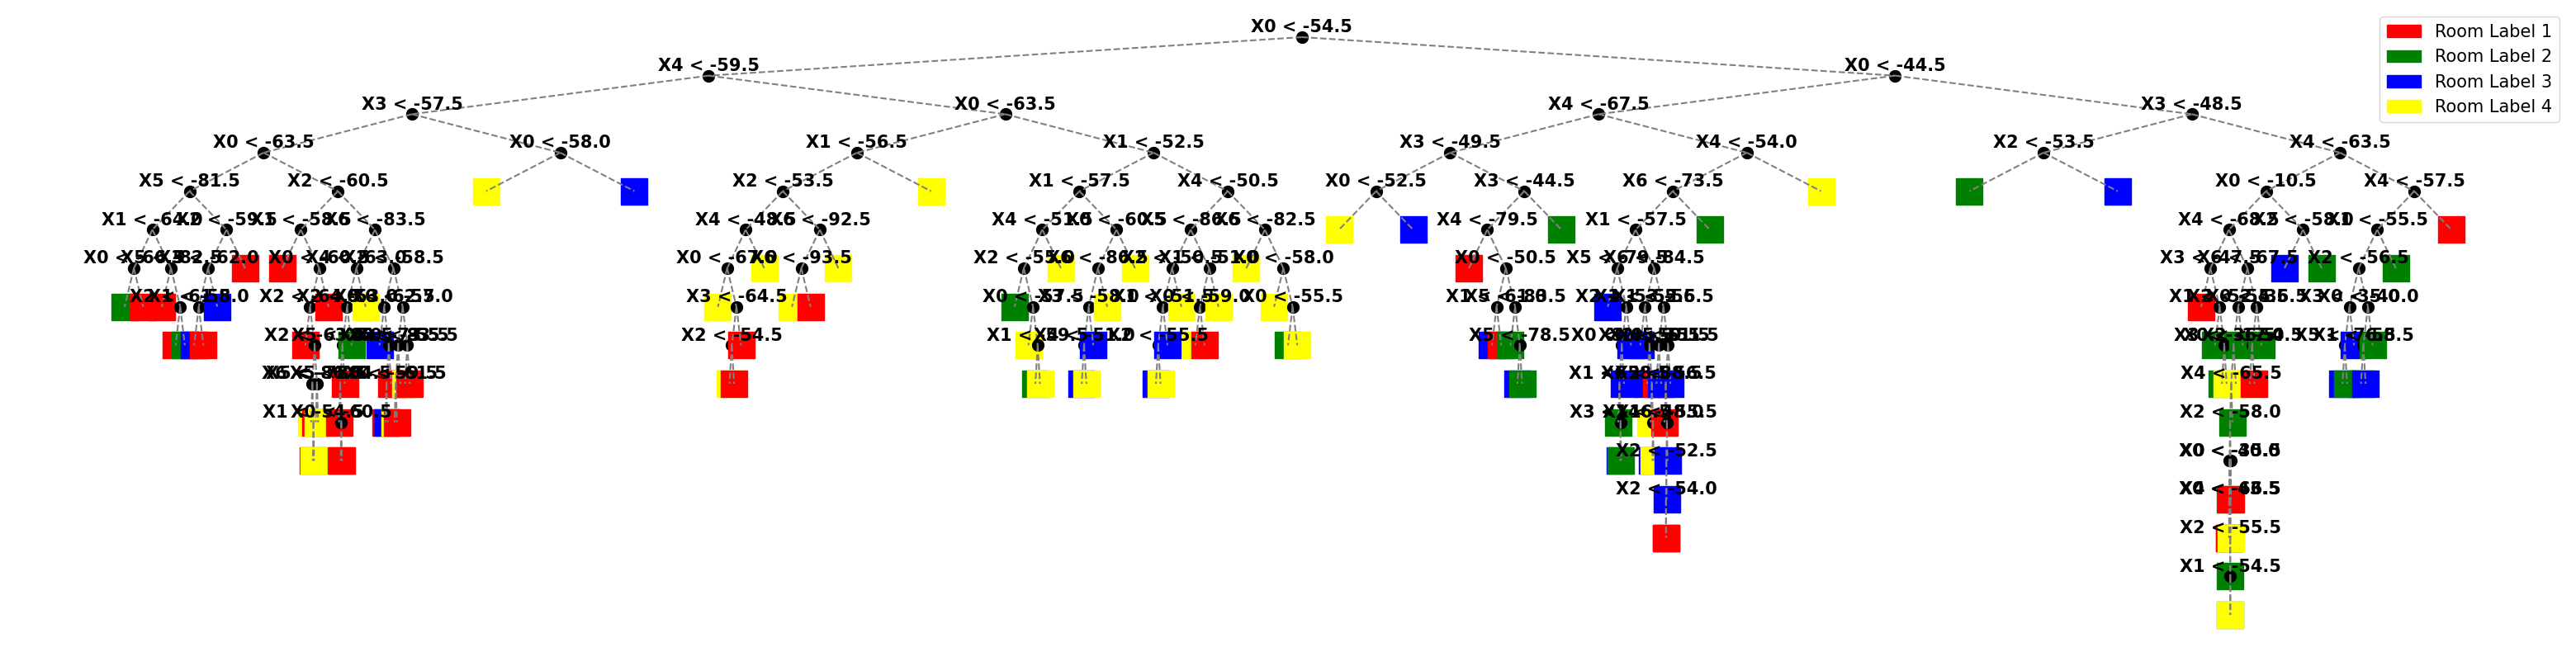

The pruned tree test accuracy: 0.84


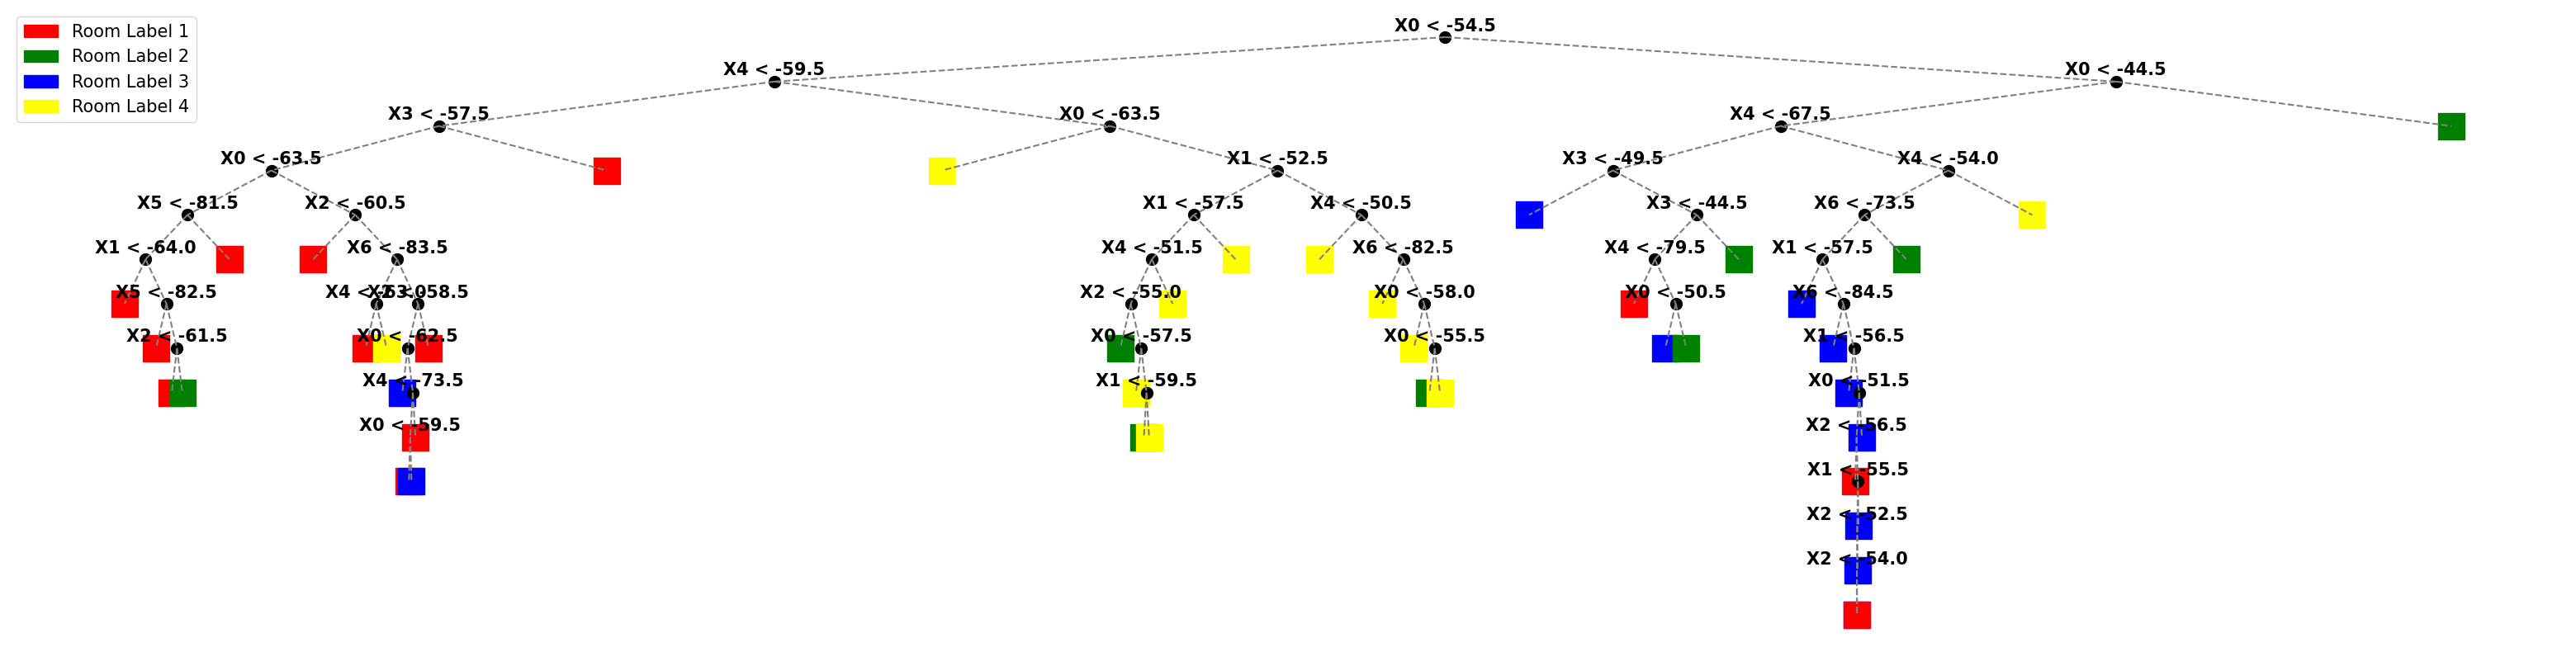

In [16]:
np.random.shuffle(noisy)

root, _ = decisionTreeLearning(noisy[:800], max_depth=50)
print('The unpruned tree test accuracy:', decision_tree_acc(root, noisy[1600:]))

plotTree(root)

proot = decisionTreePruning(root, noisy[800:1600])
print('The pruned tree test accuracy:', decision_tree_acc(proot, noisy[1600:]))

plotTree(proot)

## Evaluation of pruning the decision tree

In [19]:
def kFoldTrainTestVal(data: np.ndarray, ind_test: int, ind_val: int, number_folds = 10) -> tuple[np.ndarray, np.ndarray, np.ndarray]:
    '''
    Takes the data and splits it up into folds of, it then returns the fold indexed by ind_test as the test data, 
    the fold indexed by ind_val as the validation data and the remaining folds as training data

    inputs: data, np.ndarray of data
            ind_test, int the fold number to use for testing
            number_folds, int the number of folds to split the data into
    outputs: fold_test, the data fold for testing
             fold_val, the data fold for validation
             fold_train, the remaining training data
    '''
    folds = np.array_split(data, number_folds)
    fold_test = folds[ind_test]
    fold_val = folds[ind_val]
    folds = np.delete(folds, [ind_test, ind_val], axis=0)
    fold_train = np.concatenate(folds)

    return fold_test, fold_val, fold_train

In [20]:
def kFoldCrossValidationPruning(data_set: np.ndarray, max_depth=100, number_folds = 10, pruning_iterations = 100) -> tuple:
    '''
    Takes the data for which to perform k-fold cross validation, the max depth of the decision trees to train,
    the number of folds to do and how many pruning iterations to prune for. Returns average confusion matrix data across all folds.

    inputs: data_set, np.ndarray of data
            max_depth, int stating the max depth of decision trees it trains
            number_folds, int stating the number of folds for k-folds cross validation
            pruning_iterations, int stating how many iterations to prune for
    outputs: np.ndarray of the average confusion matrix across all folds 
    '''

    def sumDepths(node, depth=0):
        if node is None:
            return 0
        else:
            return sumDepths(node['left'], depth + 1) + sumDepths(node['right'], depth + 1) + depth

    def countNodes(node):
        if node is None:
            return 0
        else:
            return countNodes(node['left']) + countNodes(node['right']) + 1

    def averageDepth(node):
        return sumDepths(node) / countNodes(node)
        
    def collectDepths(node, depth=0):
        if node is None:
            return []
        else:
            return collectDepths(node['left'], depth + 1) + collectDepths(node['right'], depth + 1) + [depth]

    def medianDepth(node):
        depths = np.array(collectDepths(node))
        return np.median(depths)
    

    cm_tot = np.zeros((4,4))
    labels = np.unique(data_set[:, -1])
    
    root_depth = []
    proot_depth = []

    for ind_test in range(number_folds):
        for ind_val in range(number_folds):
            if ind_test == ind_val:
                continue
        
            # Get fold
            fold_test, fold_val, fold_train = kFoldTrainTestVal(data_set, ind_test, ind_val)

            # Train on the training data
            root, _ = decisionTreeLearning(fold_train, max_depth=max_depth)
            root_depth += [(averageDepth(root), medianDepth(root))]


            # Prune on the validation data    
            proot = decisionTreePruning(root, fold_val, pruning_iterations)
            proot_depth += [(averageDepth(proot), medianDepth(root))]

            # Get prediction from pruned test
            y_true = fold_test[:, -1]
            y_prediction = decisionTreeClassifier(fold_test, proot)
            
            # Add to total cm to average later on
            cm_addition, _ = confusion_matrix(y_true, y_prediction, class_labels = labels)

            cm_tot = cm_tot + cm_addition

    avg_cm = np.round(cm_tot / (number_folds*(number_folds-1)), decimals=1)
    avg_root_depth = (sum(root_depth[0]) / len(root_depth[0]), sum(root_depth[1]) / len(root_depth[1]))
    avg_proot_depth = (sum(proot_depth[0]) / len(proot_depth[0]), sum(proot_depth[1]) / len(proot_depth[1]))

    return avg_cm, avg_root_depth, avg_proot_depth

### Evaluation of pruning on clean dataset

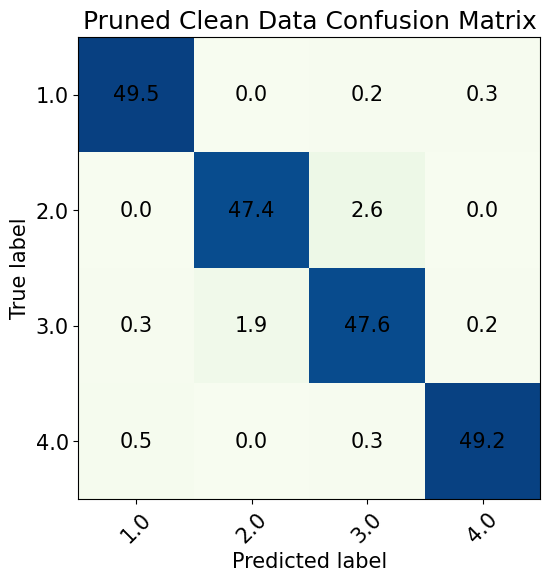

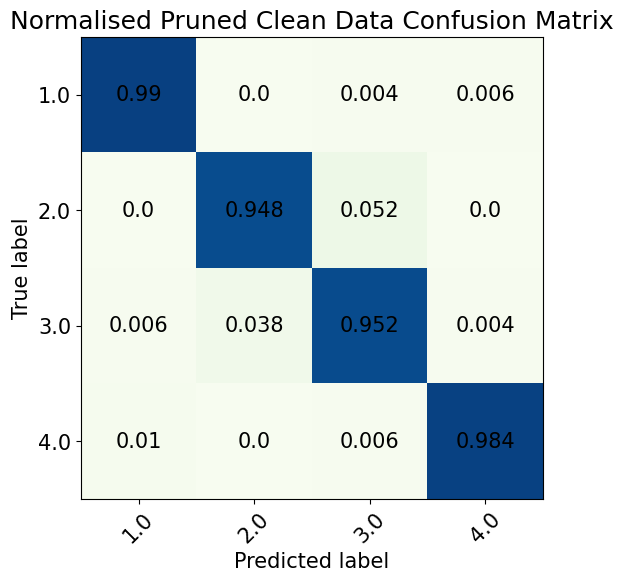

Clean Data
Accuracy: 0.9684999999999999
Precision: (array([0.98409543, 0.96146045, 0.93885602, 0.98993964]), 0.9685878818222267)
Recall: (array([0.99 , 0.948, 0.952, 0.984]), 0.9684999999999999)
F-measure: (array([0.98703888, 0.95468278, 0.94538232, 0.98696088]), 0.9685162172969877)
Avg Root Depth: 5.3311688311688314, avg root median 5.30281690140845
Avg Proot Depth: 5.803921568627451, avg rroot median 4.588235294117647


In [21]:
# Setting parameters for both Noisy and clean dataset
number_folds = 10
class_labels = np.unique(clean[:, -1])
expected_class_occurence_per_fold = len(clean) / (number_folds * len(class_labels))

# Performing k-fold CV on clean dataset
cm_pruned, avg_root_depth, avg_proot_depth = kFoldCrossValidationPruning(data_set = clean)

# Getting normalised confusion matrix data
cm_pruned_normalised = np.round(cm_pruned / expected_class_occurence_per_fold, decimals=3)

# Plotting confusion matrices
plot_confusion_matrix(cm_pruned, class_labels, "Pruned Clean Data")
plot_confusion_matrix(cm_pruned_normalised, class_labels, "Normalised Pruned Clean Data")

# Calculate evaluation metrics
print("Clean Data")
print("Accuracy: " + str(accuracy(cm_pruned)))
print("Precision: " + str(precision(cm_pruned)))
print("Recall: " + str(recall(cm_pruned)))
print("F-measure: " + str(f_measure(cm_pruned)))
print("Avg unpruned average tree Depth: {}, Avg unpruned tree median depth {}".format(avg_root_depth[0], avg_root_depth[1]))
print("Avg pruned average tree Depth: {}, Avg pruned tree median depth {}".format(avg_proot_depth[0], avg_proot_depth[1]))


### Evaluation of pruning on noisy dataset

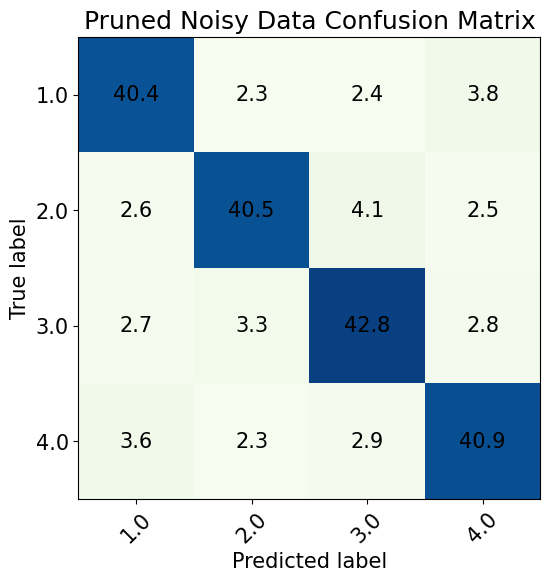

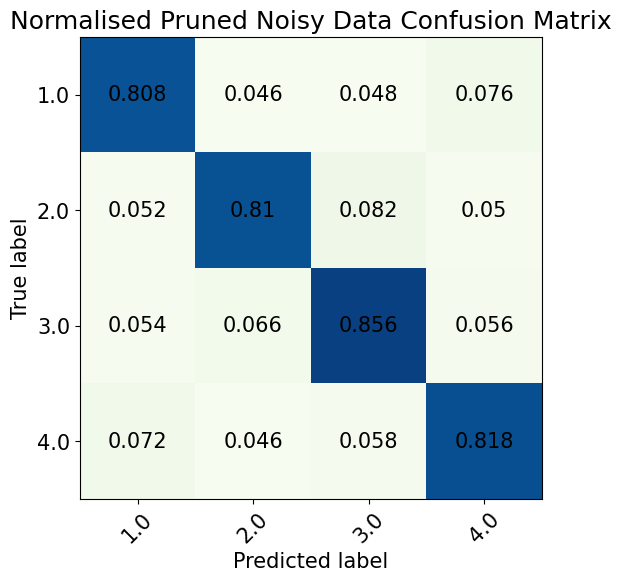

Noisy Data
Accuracy: 0.8234117058529264
Precision: (array([0.81947262, 0.83677686, 0.81992337, 0.818     ]), 0.8235432119461256)
Recall: (array([0.82617587, 0.81488934, 0.82945736, 0.82293763]), 0.8233650488080908)
F-measure: (array([0.82281059, 0.82568807, 0.82466281, 0.82046138]), 0.8234057153201092)
Avg unpruned average tree Depth: 9.86654478976234, Avg unpruned tree median depth 10.032380952380953
Avg pruned average tree Depth: 9.794816414686824, Avg pruned tree median depth 9.197732997481108


In [23]:
# Performing k-fold CV on noisy dataset
cm_pruned, avg_root_depth, avg_proot_depth = kFoldCrossValidationPruning(data_set = noisy)

# Getting normalised confusion matrix data
cm_pruned_normalised = np.round(cm_pruned / expected_class_occurence_per_fold, decimals=3)

# Plotting confusion matrices
plot_confusion_matrix(cm_pruned, class_labels, "Pruned Noisy Data")
plot_confusion_matrix(cm_pruned_normalised, class_labels, "Normalised Pruned Noisy Data")

# Calculate evaluation metrics
print("Noisy Data")
print("Accuracy: " + str(accuracy(cm_pruned)))
print("Precision: " + str(precision(cm_pruned)))
print("Recall: " + str(recall(cm_pruned)))
print("F-measure: " + str(f_measure(cm_pruned)))
print("Avg unpruned average tree Depth: {}, Avg unpruned tree median depth {}".format(avg_root_depth[0], avg_root_depth[1]))
print("Avg pruned average tree Depth: {}, Avg pruned tree median depth {}".format(avg_proot_depth[0], avg_proot_depth[1]))